In [1]:
import os

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
ds_path = os.path.join('datasets', 'kaggle_cataract', 'dataset')
print(ds_path)

datasets/kaggle_cataract/dataset


In [3]:
classes = os.listdir(ds_path)
NUM_CLASSES = len(classes)
class_encode = {classes[index]: index for index in range(NUM_CLASSES)}
class_decode = {index: classes[index] for index in range(NUM_CLASSES)}

print(classes)
print(class_encode)
print(class_decode)

['1_normal', '2_glaucoma', '3_retina_disease', '2_cataract']
{'1_normal': 0, '2_glaucoma': 1, '3_retina_disease': 2, '2_cataract': 3}
{0: '1_normal', 1: '2_glaucoma', 2: '3_retina_disease', 3: '2_cataract'}


In [4]:
def list_images(class_name):
    class_path = os.path.join(ds_path, class_name)
    filenames = os.listdir(class_path)

    df = pd.DataFrame(columns=['filename', 'label', 'path'])
    df['filename'] = pd.Series(filenames)
    df['label'] = class_name
    df['label_encoded'] = class_encode[class_name]
    df['path'] = df['filename'].apply(lambda file: os.path.join(class_path, file))

    return df

dfs = map(list_images, classes)
df = pd.concat(dfs).reset_index()
df

,index,filename,label,path,label_encoded
0,0,NL_092.png,1_normal,datasets/kaggle_cataract/dataset/1_normal/NL_0...,0
1,1,NL_185.png,1_normal,datasets/kaggle_cataract/dataset/1_normal/NL_1...,0
2,2,NL_053.png,1_normal,datasets/kaggle_cataract/dataset/1_normal/NL_0...,0
3,3,NL_257.png,1_normal,datasets/kaggle_cataract/dataset/1_normal/NL_2...,0
4,4,NL_146.png,1_normal,datasets/kaggle_cataract/dataset/1_normal/NL_1...,0
...,...,...,...,...,...
596,95,cataract_031.png,2_cataract,datasets/kaggle_cataract/dataset/2_cataract/ca...,3
597,96,cataract_096.png,2_cataract,datasets/kaggle_cataract/dataset/2_cataract/ca...,3
598,97,cataract_027.png,2_cataract,datasets/kaggle_cataract/dataset/2_cataract/ca...,3
599,98,cataract_059.png,2_cataract,datasets/kaggle_cataract/dataset/2_cataract/ca...,3


In [5]:
df.groupby('label').count()

,index,filename,path,label_encoded
label,,,,
1_normal,300,300,300,300
2_cataract,100,100,100,100
2_glaucoma,101,101,101,101
3_retina_disease,100,100,100,100


In [6]:
train, test = train_test_split(df, test_size=0.15, random_state=0)

In [7]:
train.to_csv('kaggle_cataract_train.csv', index=False)
test.to_csv('kaggle_cataract_test.csv', index=False)

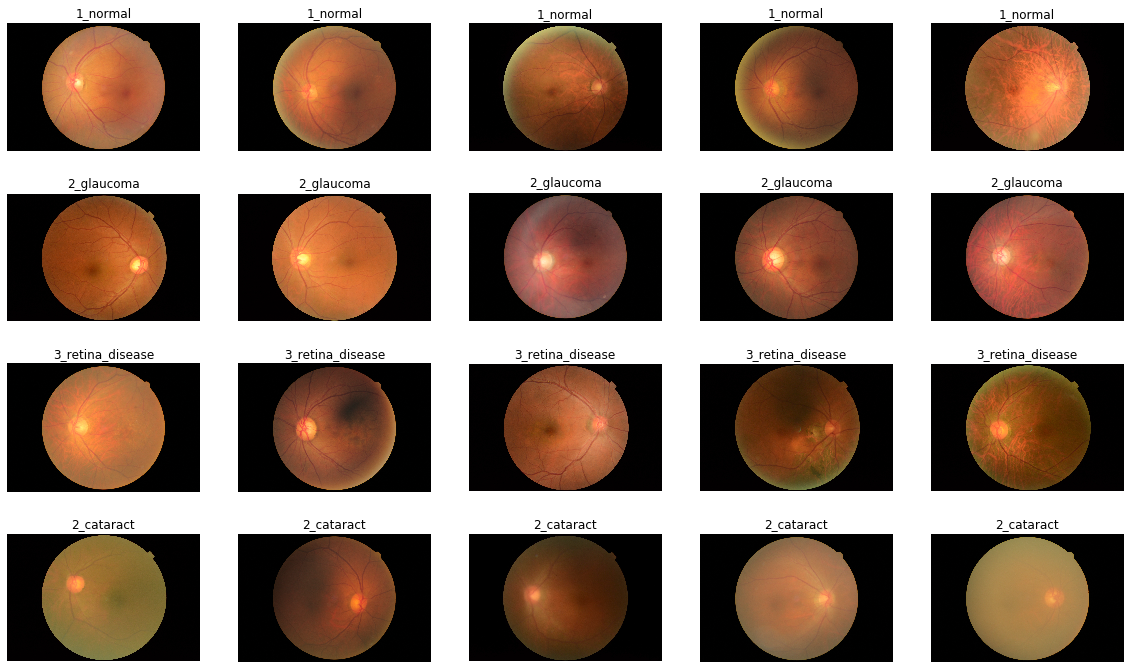

In [8]:
i = 1
plt.figure(figsize=(20,12))
for class_name in classes:
    samples = df[df['label'] == class_name].sample(5)

    def load_image(path):
        img = tf.io.read_file(path)
        img = tf.image.decode_png(img)

        return img
    
    images = samples['path'].apply(load_image)

    for img in images:
        plt.subplot(NUM_CLASSES, 5, i)
        plt.imshow(img.numpy())
        plt.axis('off')
        plt.title(class_name)
        i += 1

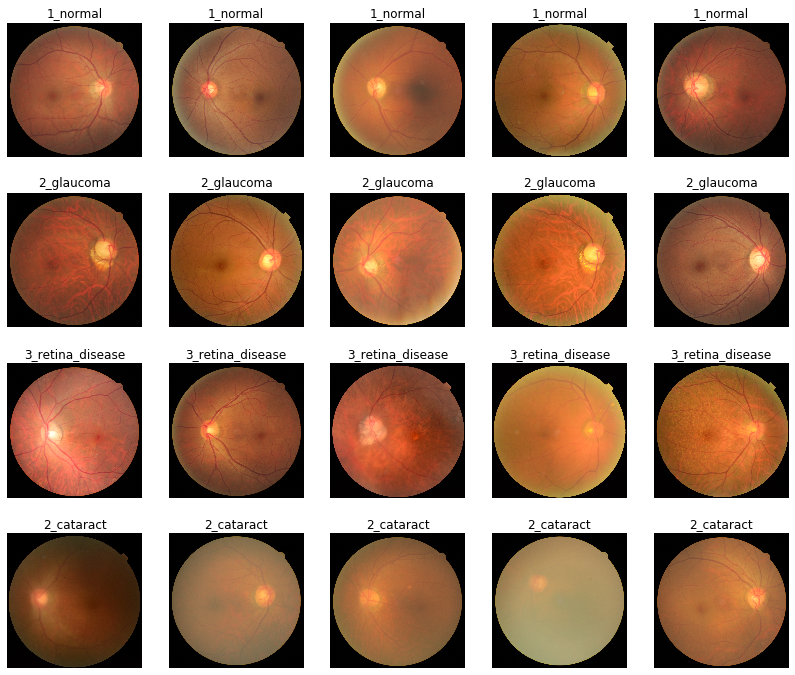

In [9]:
i = 1
plt.figure(figsize=(14,12))
for class_name in classes:
    samples = df[df['label'] == class_name].sample(5)

    def load_image(path):
        img = tf.io.read_file(path)
        img = tf.image.decode_png(img)
        height, width, _ = img.shape
        offset_width = int((width - height) / 2)
        img = tf.image.crop_to_bounding_box(img, offset_height=0, offset_width=offset_width, target_height=height, target_width=height)

        return img
    
    images = samples['path'].apply(load_image)

    for img in images:
        plt.subplot(NUM_CLASSES, 5, i)
        plt.imshow(img.numpy())
        plt.axis('off')
        plt.title(class_name)
        i += 1

In [10]:
IMG_DIM = 224

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Crop
    height = tf.shape(img)[0]
    img = tf.image.resize_with_crop_or_pad(img, height, height)
    img = tf.image.resize(img, [IMG_DIM, IMG_DIM])

    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((df['path'], df['label_encoded']))
train_ds = train_ds.map(load_image)

tf.Tensor(0, shape=(), dtype=int64)
(224, 224, 3)


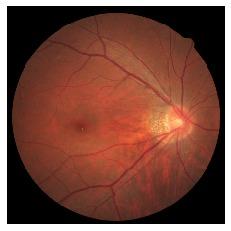

In [11]:
for img, label in train_ds.take(1):
    print(label)
    print(img.shape)
    plt.imshow(img)
    plt.axis('off')